In [ ]:
%pip install shap
%pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

In [ ]:
# Load Data
data_path = "MachineLearningRating_v3.txt"
data = pd.read_csv(data_path, sep='|', engine='python')


In [ ]:
data.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims'],
      dtype='object')

In [ ]:
# Data Preparation
data.fillna(data.median(numeric_only=True), inplace=True)
data.dropna(subset=['TotalPremium', 'TotalClaims'], inplace=True)

# Encoding Categorical Data
categorical_cols = data.select_dtypes(include=['object']).columns
encoded_data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Feature Engineering
encoded_data['PremiumToClaimsRatio'] = encoded_data['TotalPremium'] / (encoded_data['TotalClaims'] + 1)

In [ ]:
# Handling Missing Data
data.fillna(data.median(numeric_only=True), inplace=True)
data.dropna(subset=['TotalPremium', 'TotalClaims'], inplace=True)

# Check and fill remaining NaN values after encoding
encoded_data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
encoded_data.fillna(0, inplace=True)

# Feature Engineering
encoded_data['PremiumToClaimsRatio'] = encoded_data['TotalPremium'] / (encoded_data['TotalClaims'] + 1)

# Train-Test Split
target = 'TotalPremium'
features = encoded_data.drop(columns=['TotalPremium'])
X_train, X_test, y_train, y_test = train_test_split(features, encoded_data[target], test_size=0.3, random_state=42)

# Confirm no NaN values
assert not X_train.isnull().values.any(), "Training data contains NaN values."
assert not X_test.isnull().values.any(), "Test data contains NaN values."

In [ ]:
# Model Building
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

In [ ]:
X_train.isnull().sum()

,0
UnderwrittenCoverID,0
PolicyID,0
IsVATRegistered,0
PostalCode,0
mmcode,0
...,...
CoverGroup_Income Protector,0
Section_Motor Comprehensive,0
Section_Optional Extended Covers,0
Product_Mobility Metered Taxis: Monthly,0


In [ ]:
results ={}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate Models
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

Training Linear Regression...
Training Random Forest...
Training XGBoost...


In [ ]:
# Display Results
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
                        MAE         MSE        R2
Linear Regression  3.277894  187.473809  0.994614
Random Forest      0.393232   10.310297  0.999704
XGBoost            0.712829   62.720269  0.998198


In [ ]:
# Convert boolean columns to integers
bool_columns = X_train.select_dtypes(include=['bool']).columns
X_train[bool_columns] = X_train[bool_columns].astype(int)
X_test[bool_columns] = X_test[bool_columns].astype(int)

In [ ]:

print(X_train.dtypes.value_counts())

int64      171
float64     15
Name: count, dtype: int64


In [ ]:
# Step 4: Model Interpretability
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]

In [ ]:
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

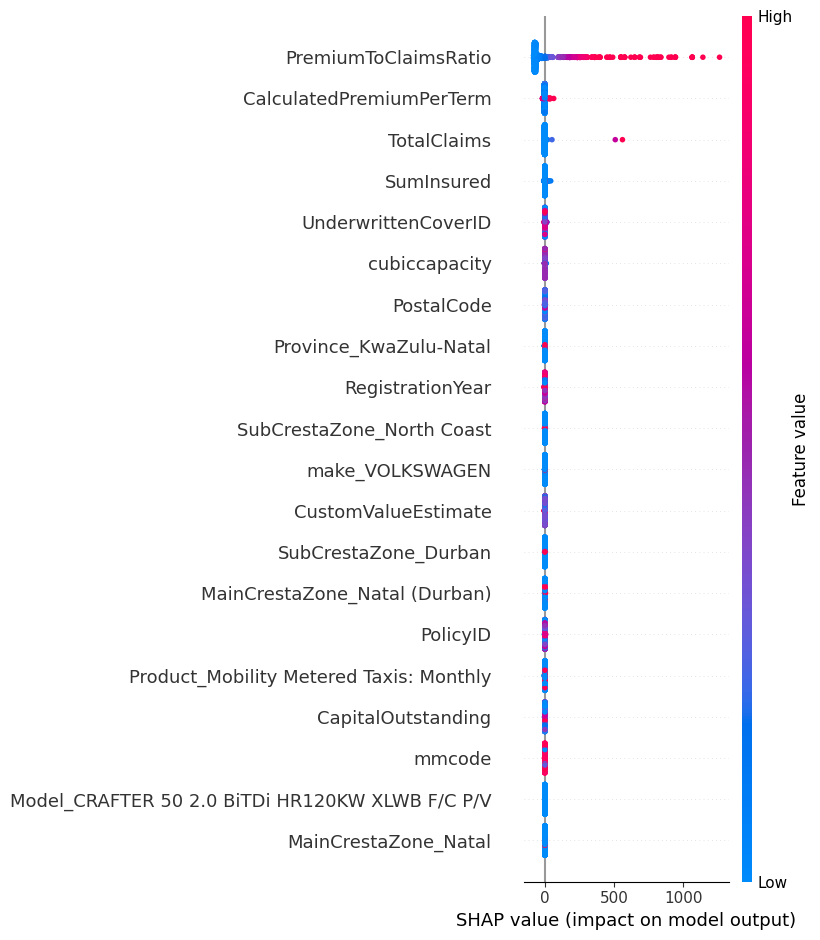

In [ ]:
# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)

In [ ]:
# Save Results
results_df.to_csv("model_evaluation_results.csv", index=True)

In [ ]:
df = pd.read_csv("model_evaluation_results.csv")

In [ ]:
df. head()

,Unnamed: 0,MAE,MSE,R2
0,Linear Regression,3.277894,187.473809,0.994614
1,Random Forest,0.393232,10.310297,0.999704
2,XGBoost,0.712829,62.720269,0.998198
